## Word2vec model training
#### Model training based on three datasets' text data:
- M1: pwdb + eu_timeline  ( +  ireland_timeline )
- M2: ds_eu_cellar
- M3: M1+M2

#### Extract NOUN and NOUN PHRASES from each text data
#### Train the word2vec model with each dataset's textual data

### Import libraries

In [102]:
import sys

import numpy as np

sys.path.append("/home/jovyan/work/sem-covid/")
sys.path = list(set(sys.path))

import os

os.getcwd()
os.chdir('/home/jovyan/work/sem-covid/')

import warnings

warnings.filterwarnings("ignore", category=DeprecationWarning)

from typing import List, Tuple

import spacy

nlp = spacy.load('en_core_web_sm')

import pandas as pd
from gensim.models import Word2Vec
import plotly.express as px

from sem_covid.services.data_registry import Dataset
from sem_covid.adapters.data_source import IndexTabularDataSource

from sem_covid.entrypoints.notebooks.topic_modeling.topic_modeling_wrangling.token_management import (filter_pos,
    select_pos, filter_pos, filter_stop_words)

from sem_covid.services.sc_wrangling.data_cleaning import (clean_text_from_specific_characters, clean_fix_unicode,
                                                           clean_remove_currency_symbols, clean_remove_emails,
                                                           clean_remove_urls, clean_remove_stopwords)

from sem_covid.entrypoints.notebooks.language_modeling.language_model_tools.similarity_calculus import (
    euclidean_similarity, manhattan_similarity, cosine_similarity, get_similarity_matrix)

from sem_covid.entrypoints.notebooks.language_modeling.language_model_tools.document_handling_tools import(
    document_atomization_noun_phrases)

from sem_covid.entrypoints.notebooks.language_modeling.language_model_tools.word_embeddings_handler import (
    select_words_and_embedding_clusters, create_tsne_model, create_word_clusters_matrix)

## Define constants

In [5]:
PWDB_TEXTUAL_CLASS = ['title', 'background_info_description', 'content_of_measure_description',
                      'use_of_measure_description', 'involvement_of_social_partners_description']

DEFAULT_TEXTUAL_COLUMN = ['title']
WINDOW = 5
MIN_COUNT = 1
VECTOR_SIZE = 300
EPOCHS = 50
EU_TIMELINE_TOTAL_EXAMPLES = 171
IRELAND_TIMELINE_TOTAL_EXAMPLES = 410
EU_CELLAR_TOTAL_EXAMPLES = 2653

## Data preprocessing
- data cleanup
- turn corpus into spacy document

In [2]:
def apply_cleaning_functions(document_corpus: pd.Series) -> pd.Series:
    """
    This function receives the document and leads through cleaning steps
    Args:
        document_corpus: dataset document corpus

    Returns: clean document corpus
    """
    unused_characters = ["\\r", ">", "\n", "\\", "<", "''", "%", "...", "\'", '"', "(", "\n", "*", "1)", "2)", "3)",
                         "[", "]", "-", "_", "\r"]

    new_document_corpus = document_corpus.apply(clean_text_from_specific_characters, characters=unused_characters)
    new_document_corpus = new_document_corpus.apply(clean_fix_unicode)
    new_document_corpus = new_document_corpus.apply(clean_remove_urls)
    new_document_corpus = new_document_corpus.apply(clean_remove_emails)
    new_document_corpus = new_document_corpus.apply(clean_remove_currency_symbols)
    new_document_corpus = new_document_corpus.apply(clean_remove_stopwords)

    return new_document_corpus

In [3]:
class LanguageModelPipeline:
    """
        This pipeline executes the steps for word2vec language training.
    """

    def __init__(self, dataset_sources: List[Tuple[IndexTabularDataSource, List[str]]]):
        """
            :param dataset_sources: represents the source of the datasets.
        """
        self.dataset_sources = dataset_sources
        self.documents_corpus = pd.Series()
        self.word2vec = None

    def download_datasets(self):
        """
            In this step it will download the dataset and detect selected columns.
            It can be downloaded as many datasets as there are in data source.
        """
        self.dataset_sources = [(dataset_columns, dataset_source.fetch())
                                for dataset_source, dataset_columns in self.dataset_sources]

    def extract_textual_data(self):
        """
            After downloading the datasets, the textual data will be found and and concatenated
            with executing of several steps as well. It will fill the NaN values with empty space,
            add a dot at the end of each concatenated column and reset the index.
        """
        self.documents_corpus = pd.concat([dataset[columns]
                                          .fillna(value="")
                                          .agg('. '.join, axis=1)
                                          .reset_index(drop=True)
                                           for columns, dataset in self.dataset_sources
                                           ], ignore_index=True)

    def clean_textual_data(self):
        """
            The next step is data cleaning. In this step the function "apply_cleaning_functions"
            applies the following actions:
                - clean the document from specific characters
                - delete unicode
                - removes emails and URLs and currency symbols
        """
        self.documents_corpus = apply_cleaning_functions(self.documents_corpus)

    def transform_to_spacy_doc(self):
        """
            When the document is clean, is going to be transform into spacy document
        """
        self.documents_corpus = self.documents_corpus.apply(nlp)

    def extract_features(self):
        """
            To extract the parts of speech, below it was defined classes for each token is necessary.
        """
        self.documents_corpus = pd.concat([self.documents_corpus,
                                           self.documents_corpus.apply(document_atomization_noun_phrases)]
                                          , ignore_index=True)

        self.documents_corpus = self.documents_corpus.apply(lambda x: list(map(str, x)))

    def model_training(self):
        """
            When the data is prepared it's stored into Word2Vec model.
        """
        self.word2vec = Word2Vec(sentences=self.documents_corpus, window=WINDOW,
                                 min_count=MIN_COUNT, vector_size=VECTOR_SIZE)

    def execute(self):
        """
            The final step is execution, where are stored each step and it will be executed in a row
        """
        self.download_datasets()
        self.extract_textual_data()
        self.clean_textual_data()
        self.transform_to_spacy_doc()
        self.extract_features()
        self.model_training()

## Experiment Nr#1 language model based on:
- PWDB
- eu-timeline
- ireland-timeline

In [6]:
dataset_sources_config = [
    (Dataset.PWDB, PWDB_TEXTUAL_CLASS),
    (Dataset.EU_ACTION_TIMELINE, DEFAULT_TEXTUAL_COLUMN),
    (Dataset.IRELAND_ACTION_TIMELINE, DEFAULT_TEXTUAL_COLUMN)
]
model1_language_model_pipeline = LanguageModelPipeline(dataset_sources=dataset_sources_config)
model1_language_model_pipeline.execute()

100% (1288 of 1288) |####################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (171 of 171) |######################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (410 of 410) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


## Experiment Nr#2 language model based on:
- eu-cellar


In [7]:
dataset_sources_config = [
    (Dataset.EU_CELLAR, DEFAULT_TEXTUAL_COLUMN)
]
model2_language_model_pipeline = LanguageModelPipeline(dataset_sources=dataset_sources_config)
model2_language_model_pipeline.execute()


100% (2653 of 2653) |####################| Elapsed Time: 0:00:01 Time:  0:00:01


In [87]:
import spacy

nlp = spacy.load('en_core_web_sm')
doc = nlp(str(model2_language_model_pipeline.word2vec.wv.index_to_key))
selected_pos = select_pos(doc, pos=['NOUN', 'ADJ'])

In [88]:
selected_pos = list(map(str, selected_pos))

In [89]:
selected_pos

['european',
 'council',
 'commission',
 'regulation',
 'parliament',
 'case',
 'decision',
 'regards',
 'committee',
 'covid19',
 'document',
 'union',
 'certain',
 'text',
 'relevance',
 'article',
 'social',
 'communication',
 'proposal',
 'economic',
 'opinion',
 'preliminary',
 'request',
 'programme',
 'action',
 'air',
 'recommendation',
 'outbreak',
 'regions',
 'directive',
 'state',
 'services',
 'staff',
 'rules',
 'aid',
 'court',
 'measures',
 'common',
 'temporary',
 'member',
 'information',
 'periodic',
 'l',
 'states',
 'community',
 'use',
 'pursuant',
 'accordance',
 'law',
 'text_eea_relevance',
 'p.',
 'application',
 'recovery',
 'pandemic',
 'plan',
 'respect',
 'support',
 'assessment',
 'rule',
 'health',
 'agreement',
 'public',
 'evaluation',
 'market',
 'transport',
 'training',
 'position',
 'operation',
 'european_economic_social_committee_committee_regions',
 'service',
 'framework',
 'judgment',
 'postponement',
 'final',
 'products',
 'specific',
 'gene

In [92]:
selected_pos_index = [model2_language_model_pipeline.word2vec.wv.index_to_key.index(token)
                      for token in selected_pos
                      if token in model2_language_model_pipeline.word2vec.wv.index_to_key
                      ]

In [93]:
selected_pos_embeddings = [model2_language_model_pipeline.word2vec.wv.vectors[index]
                           for index in selected_pos_index
                           ]

In [95]:
len(selected_pos_embeddings)

5176

In [104]:
def my_get_similarity_matrix(vector: np.ndarray, keys: list, metric: callable) -> pd.DataFrame:
    """
        creates a dataframe based on keys and vectors from pretrained gensim model
        and selected similarity function

        :param vector: the object that contains the mapping between words and embeddings
        :param keys: words indexes keys
        :metric: metric distance formula
        :return: dataframe with similarity of each word
    """
    from sklearn.metrics import pairwise_distances
    return pd.DataFrame(pairwise_distances(vector, metric=metric), columns=keys, index=keys)

In [150]:
sim_matrix =  my_get_similarity_matrix(selected_pos_embeddings[:50],
                      selected_pos[:50],
                      metric=cosine_similarity)

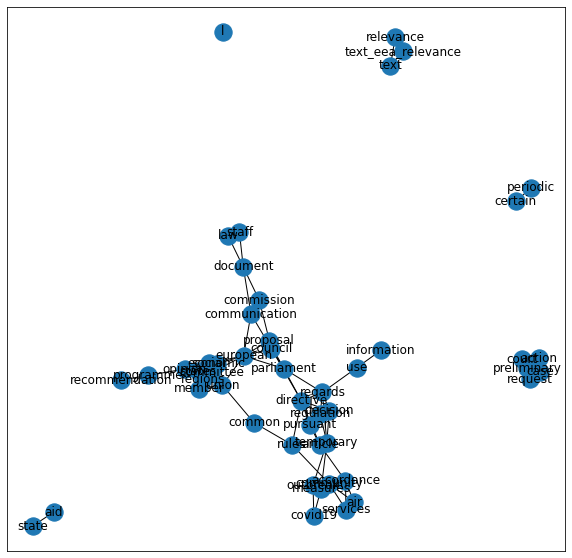

In [155]:
import networkx as nx
import matplotlib.pyplot as plt
graph = nx.Graph()
graph.add_nodes_from(sim_matrix.index)
threshold = 0.9
n = np.array(sim_matrix.values).shape[0]
m = np.array(sim_matrix.values).shape[1]
for i in range(0,n):
    for j in range(i+1,m):
        if sim_matrix.values[i][j]>threshold :
            graph.add_edge(sim_matrix.index[i], sim_matrix.index[j], weight = sim_matrix.values[i][j])
plt.figure(1,figsize=(10,10))
nx.draw_networkx(graph, with_labels=True)


In [68]:
len(selected_pos)

5177

In [63]:
from gensim.models import KeyedVectors


def restrict_word2vec_tokens(word2vec: KeyedVectors, restricted_word_set: set) -> None:
    """
    This function will receive the existed word2vec model and the words we want to reduce
    our model
    Args:
        word2vec: existed gensim word2vec model
        restricted_word_set: set of words

    Returns: word2vec model only with restricted set of words
    """

    new_vectors = []
    new_vocabulary = []
    new_index2entity = []
    new_vectors_norm = []

    for index in range(len(word2vec.vocab)):
        word = word2vec.index2entity[index]
        vector = word2vec.vectors[index]
        vocabulary = word2vec.vocab[word]
        vector_normed = word2vec.vectors_norm[index]

        if word in restricted_word_set:
            vocabulary.index = len(new_index2entity)
            new_index2entity.append(word)
            new_vocabulary[word] = vocabulary
            new_vectors.append(vector)
            new_vectors_norm.append(vector_normed)

    word2vec.vocab = new_vocabulary
    word2vec.vectors = np.array(new_vectors)
    word2vec.index2entity = np.array(new_index2entity)
    word2vec.index2word = np.array(new_index2entity)
    word2vec.vectors_norm = np.array(new_vectors_norm)

In [69]:
restricted_word2vec = restrict_word2vec_tokens(model1_language_model_pipeline.word2vec.wv, set(selected_pos))

AttributeError: The vocab attribute was removed from KeyedVector in Gensim 4.0.0.
Use KeyedVector's .key_to_index dict, .index_to_key list, and methods .get_vecattr(key, attr) and .set_vecattr(key, attr, new_val) instead.
See https://github.com/RaRe-Technologies/gensim/wiki/Migrating-from-Gensim-3.x-to-4

## Experiment Nr#3 language model based on:
- PWDB
- eu-timeline
- ireland-timeline
- eu-cellar

In [8]:
dataset_sources_config = [
    (Dataset.PWDB, PWDB_TEXTUAL_CLASS),
    (Dataset.EU_ACTION_TIMELINE, DEFAULT_TEXTUAL_COLUMN),
    (Dataset.IRELAND_ACTION_TIMELINE, DEFAULT_TEXTUAL_COLUMN),
    (Dataset.EU_CELLAR, DEFAULT_TEXTUAL_COLUMN)
]
model3_language_model_pipeline = LanguageModelPipeline(dataset_sources=dataset_sources_config)
model3_language_model_pipeline.execute()

## Similarity matrices
### Euclidean similarity


In [497]:
model1_euclidean_similarity_matrix = get_similarity_matrix(model1_language_model_pipeline.word2vec.wv.vectors[:10000],
                                                           model1_language_model_pipeline.word2vec.wv.index_to_key[
                                                           :10000],
                                                           metric=euclidean_similarity)
model1_euclidean_similarity_matrix

TypeError: get_similarity_matrix() got an unexpected keyword argument 'metric'

In [389]:
def select_most_similar_words(document: pd.Series, percentage: float) -> pd.Series:
    """
        It locate the rows with equal and above inserted percentage number
    """
    return document.loc[document >= percentage]


companies_column = select_most_similar_words(model1_euclidean_similarity_matrix['companies'], percentage=0.12)
covid_column = select_most_similar_words(model1_euclidean_similarity_matrix['covid'], percentage=0.20)
economic_column = select_most_similar_words(model1_euclidean_similarity_matrix['economic'], percentage=0.12)
country_column = select_most_similar_words(model1_euclidean_similarity_matrix['country'], percentage=0.4)
workers_column = select_most_similar_words(model1_euclidean_similarity_matrix['workers'], percentage=0.13)

In [470]:
# leaf for companies_column

businesses_column = select_most_similar_words(model1_euclidean_similarity_matrix['businesses'], percentage=0.15)
business_column = select_most_similar_words(model1_euclidean_similarity_matrix['business'], percentage=0.175)
sectors_column = select_most_similar_words(model1_euclidean_similarity_matrix['sectors'], percentage=0.169)
enterprises_column = select_most_similar_words(model1_euclidean_similarity_matrix['enterprises'], percentage=0.16)

In [471]:
enterprises_column

businesses       0.188833
business         0.177638
sectors          0.185326
enterprises      1.000000
small            0.191056
smes             0.192827
entrepreneurs    0.169911
cultural         0.163353
micro            0.163858
Name: enterprises, dtype: float64

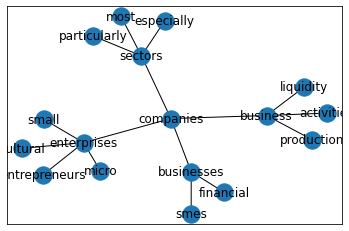

In [478]:
"""
    1. create a graph for each keywords
        - Root node: Key word
        - Node: top 5 words i.e.
        - Leaf node: top 5 words i.e
    2. visualize using pyplot
"""

import networkx as nx

graph = nx.Graph()
graph.add_nodes_from(companies_column.index)
graph.add_nodes_from(businesses_column.index)
graph.add_nodes_from(business_column.index)
graph.add_nodes_from(sectors_column.index)
graph.add_nodes_from(enterprises_column.index)
graph.add_edge(companies_column.index[0], companies_column.index[1])
graph.add_edge(companies_column.index[0], companies_column.index[2])
graph.add_edge(companies_column.index[0], companies_column.index[3])
graph.add_edge(companies_column.index[0], companies_column.index[4])
graph.add_edge(companies_column.index[1], businesses_column.index[3])
graph.add_edge(companies_column.index[1], businesses_column.index[5])
graph.add_edge(companies_column.index[1], businesses_column.index[5])
graph.add_edge(companies_column.index[2], business_column.index[1])
graph.add_edge(companies_column.index[2], business_column.index[3])
graph.add_edge(companies_column.index[2], business_column.index[4])
graph.add_edge(companies_column.index[3], sectors_column.index[3])
graph.add_edge(companies_column.index[3], sectors_column.index[4])
graph.add_edge(companies_column.index[3], sectors_column.index[5])
graph.add_edge(companies_column.index[4], enterprises_column.index[4])
graph.add_edge(companies_column.index[4], enterprises_column.index[6])
graph.add_edge(companies_column.index[4], enterprises_column.index[7])
graph.add_edge(companies_column.index[4], enterprises_column.index[8])
nx.draw_networkx(graph, with_labels=True)


In [498]:
% % time
model2_euclidean_similarity_matrix = get_similarity_matrix(model2_language_model_pipeline.word2vec.wv.vectors[:100],
                                                           model2_language_model_pipeline.word2vec.wv.index_to_key[
                                                           :100],
                                                           metric=euclidean_similarity)
model2_euclidean_similarity_matrix

TypeError: get_similarity_matrix() got an unexpected keyword argument 'metric'

In [ ]:
% % time
model3_euclidean_similarity_matrix = get_similarity_matrix(model3_language_model_pipeline.word2vec.wv.vectors[:100],
                                                           model3_language_model_pipeline.word2vec.wv.index_to_key[
                                                           :100],
                                                           metric=euclidean_similarity)
model3_euclidean_similarity_matrix

### Cosine similarity

In [205]:
% % time
model1_cosine_similarity_matrix = get_similarity_matrix(model1_language_model_pipeline.word2vec.wv.vectors[:100],
                                                        model1_language_model_pipeline.word2vec.wv.index_to_key[:100],
                                                        metric=cosine_similarity)
model1_cosine_similarity_matrix

CPU times: user 65.2 ms, sys: 15.6 ms, total: 80.8 ms
Wall time: 59 ms


,of,the,",",.,to,and,in,for,is,),...,amount,april,state,after,must,other,out,the_government,public,those
of,1.000000,0.511642,0.317369,0.427981,0.262384,0.166899,0.430036,0.390382,0.212310,0.281808,...,0.410233,0.317030,0.568288,0.428808,0.148485,0.214645,0.112346,0.301171,0.355986,0.142277
the,0.511642,1.000000,0.367205,0.447992,0.231155,0.365131,0.396390,0.400744,0.236863,0.162178,...,0.391036,0.308467,0.669853,0.368698,0.244276,0.423464,0.382931,0.368911,0.534336,0.304475
",",0.317369,0.367205,1.000000,0.616912,0.176355,0.484668,0.492602,0.330994,0.060653,0.465698,...,0.258271,0.507750,0.378864,0.338123,0.176744,0.437537,0.076684,0.285540,0.516604,0.373788
.,0.427981,0.447992,0.616912,1.000000,0.329643,0.291583,0.422859,0.419060,0.230321,0.285206,...,0.443402,0.429274,0.406013,0.350010,0.154066,0.308056,0.196495,0.413613,0.385117,0.232044
to,0.262384,0.231155,0.176355,0.329643,1.000000,0.305928,0.275401,0.399800,0.141753,-0.146078,...,0.300556,0.185963,0.359055,0.365155,0.433441,0.277649,0.373292,0.312893,0.255106,0.292648
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
other,0.214645,0.423464,0.437537,0.308056,0.277649,0.493363,0.336355,0.388673,0.190559,0.213142,...,0.171243,0.071470,0.279163,0.028832,0.336239,1.000000,0.343986,0.061862,0.751860,0.676652
out,0.112346,0.382931,0.076684,0.196495,0.373292,0.173836,0.171435,0.347778,0.416633,0.046239,...,0.549789,0.025964,0.366920,0.351489,0.572527,0.343986,1.000000,0.242004,0.217294,0.462034
the_government,0.301171,0.368911,0.285540,0.413613,0.312893,0.146449,0.286634,0.135417,0.281205,0.138170,...,0.194754,0.494172,0.600352,0.351659,-0.016875,0.061862,0.242004,1.000000,0.339275,0.088083
public,0.355986,0.534336,0.516604,0.385117,0.255106,0.644037,0.326591,0.452979,0.221098,0.256422,...,0.196754,0.286192,0.569198,0.110868,0.247393,0.751860,0.217294,0.339275,1.000000,0.489818


In [206]:
% % time
model2_cosine_similarity_matrix = get_similarity_matrix(model2_language_model_pipeline.word2vec.wv.vectors[:100],
                                                        model2_language_model_pipeline.word2vec.wv.index_to_key[:100],
                                                        metric=cosine_similarity)
model2_cosine_similarity_matrix

CPU times: user 51.3 ms, sys: 23.2 ms, total: 74.5 ms
Wall time: 55.2 ms


,of,the,),and,",",to,on,for,2020,in,...,judgment,the_committee,temporary,services,may,oj,at,member,application,a_regulation
of,1.000000,0.919513,0.599951,0.947656,0.703472,0.754030,0.879130,0.778036,0.543840,0.627976,...,0.367666,0.754848,0.667112,0.513746,0.777145,0.551886,0.641478,0.749925,0.809222,0.900898
the,0.919513,1.000000,0.504786,0.929189,0.738409,0.760984,0.865588,0.793284,0.429596,0.606087,...,0.318793,0.843267,0.586336,0.454899,0.675231,0.469839,0.561699,0.775566,0.742509,0.918812
),0.599951,0.504786,1.000000,0.576147,0.500580,0.682235,0.520182,0.416882,0.808182,0.419381,...,0.393941,0.324376,0.710617,0.385144,0.828743,0.715183,0.697922,0.410403,0.696692,0.590283
and,0.947656,0.929189,0.576147,1.000000,0.848784,0.750749,0.863914,0.757040,0.475860,0.576558,...,0.278156,0.873580,0.558939,0.433281,0.695693,0.616469,0.537099,0.847107,0.778572,0.893071
",",0.703472,0.738409,0.500580,0.848784,1.000000,0.672268,0.664572,0.517347,0.326080,0.484948,...,0.203655,0.877284,0.269392,0.351259,0.451189,0.769101,0.371498,0.825501,0.573543,0.627526
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
oj,0.551886,0.469839,0.715183,0.616469,0.769101,0.697582,0.346202,0.214295,0.395893,0.668675,...,0.247026,0.477412,0.406026,0.574020,0.474577,1.000000,0.540744,0.662255,0.703493,0.348790
at,0.641478,0.561699,0.697922,0.537099,0.371498,0.532715,0.623981,0.567016,0.699277,0.652535,...,0.611162,0.355018,0.605535,0.765605,0.752855,0.540744,1.000000,0.390920,0.663108,0.630288
member,0.749925,0.775566,0.410403,0.847107,0.825501,0.762731,0.648013,0.649308,0.258216,0.718906,...,0.339592,0.854369,0.459639,0.551577,0.443153,0.662255,0.390920,1.000000,0.798837,0.618315
application,0.809222,0.742509,0.696692,0.778572,0.573543,0.838497,0.588450,0.638420,0.497833,0.828093,...,0.465299,0.549715,0.822030,0.681671,0.702459,0.703493,0.663108,0.798837,1.000000,0.658290


In [207]:
% % time
model3_cosine_similarity_matrix = get_similarity_matrix(model3_language_model_pipeline.word2vec.wv.vectors[:100],
                                                        model3_language_model_pipeline.word2vec.wv.index_to_key[:100],
                                                        metric=cosine_similarity)
model3_cosine_similarity_matrix

CPU times: user 73.6 ms, sys: 34.9 ms, total: 109 ms
Wall time: 74.6 ms


,of,the,",",to,.,and,in,for,),on,...,new,per,april,economic,until,information,people,according,there,scheme
of,1.000000,0.517598,0.330156,0.302161,0.426483,0.348656,0.409377,0.313940,0.090198,0.354965,...,0.383957,0.100236,0.315880,0.399175,0.216132,0.287085,0.193272,0.377668,0.246194,0.361347
the,0.517598,1.000000,0.326707,0.296850,0.458242,0.396159,0.451126,0.411143,0.000630,0.318740,...,0.662958,0.246877,0.283937,0.553101,0.204336,0.407991,0.361683,0.322334,0.354310,0.587098
",",0.330156,0.326707,1.000000,0.219896,0.607234,0.495254,0.401418,0.286840,0.187506,0.317036,...,0.243960,0.110493,0.359560,0.380066,0.251757,0.175510,0.245701,0.227950,0.311282,0.275004
to,0.302161,0.296850,0.219896,1.000000,0.366213,0.278209,0.269335,0.331793,-0.156538,0.160757,...,0.484082,0.045044,0.096797,0.262009,0.330030,0.430032,0.364392,-0.103651,0.336105,0.469706
.,0.426483,0.458242,0.607234,0.366213,1.000000,0.312992,0.444363,0.295865,-0.003394,0.309425,...,0.387245,0.139221,0.333483,0.329776,0.349633,0.422854,0.252052,0.216300,0.542839,0.625798
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
information,0.287085,0.407991,0.175510,0.430032,0.422854,0.235607,0.118302,0.260486,0.209223,0.237399,...,0.496221,0.079832,0.212209,0.267638,0.206856,1.000000,0.390421,0.431502,0.699569,0.495537
people,0.193272,0.361683,0.245701,0.364392,0.252052,0.347947,0.381185,0.326475,0.051318,-0.054393,...,0.458824,0.266294,0.102676,0.380082,-0.049131,0.390421,1.000000,0.036101,0.381874,0.490050
according,0.377668,0.322334,0.227950,-0.103651,0.216300,0.236613,0.155723,0.200275,0.379470,0.404213,...,0.210954,0.171828,0.470905,0.224708,0.325264,0.431502,0.036101,1.000000,0.253560,0.279595
there,0.246194,0.354310,0.311282,0.336105,0.542839,0.184449,0.276893,0.163174,0.172747,0.177331,...,0.336672,0.312214,0.258954,0.170003,0.310966,0.699569,0.381874,0.253560,1.000000,0.513993


### Manhattan similarity

In [208]:
% % time
model1_manhattan_similarity_matrix = get_similarity_matrix(model1_language_model_pipeline.word2vec.wv.vectors[:100],
                                                           model1_language_model_pipeline.word2vec.wv.index_to_key[
                                                           :100],
                                                           metric=manhattan_similarity)
model1_manhattan_similarity_matrix

CPU times: user 691 ms, sys: 186 µs, total: 691 ms
Wall time: 691 ms


,of,the,",",.,to,and,in,for,is,),...,amount,april,state,after,must,other,out,the_government,public,those
of,0.000000,145.369372,159.197990,153.799884,205.489596,180.221155,170.619345,153.312335,209.868486,162.155396,...,173.265481,190.520292,132.260149,158.967458,217.050198,173.012636,196.646430,183.850634,160.280528,196.657442
the,145.369372,0.000000,154.234455,151.507895,208.558334,157.695645,174.285012,148.547166,206.031205,173.245253,...,180.115426,185.738403,119.343301,164.266800,207.974005,149.318016,165.767461,171.268693,136.893949,176.001873
",",159.197990,154.234455,0.000000,105.035562,198.582626,122.140271,148.227426,138.849030,214.472796,120.618330,...,182.324265,147.342578,143.357648,144.723739,199.120345,127.072927,180.919378,170.439717,122.603375,153.169418
.,153.799884,151.507895,105.035562,0.000000,186.412743,152.516982,161.417585,133.394009,199.399851,143.121142,...,164.703663,158.739652,145.855554,145.500051,202.655125,143.772465,174.968635,156.271512,142.598751,172.505993
to,205.489596,208.558334,198.582626,186.412743,0.000000,186.663549,202.925813,174.547577,240.792944,232.134947,...,210.823961,224.236225,187.951252,182.545917,193.171520,194.467070,185.073991,204.048415,196.951975,207.870662
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
other,173.012636,149.318016,127.072927,143.772465,194.467070,123.677089,161.581968,131.087650,196.751425,145.768623,...,190.805325,199.656589,158.191686,181.718167,181.892070,0.000000,149.831473,193.605824,88.653901,113.858503
out,196.646430,165.767461,180.919378,174.968635,185.073991,177.277388,198.547585,154.797194,177.887159,181.469869,...,154.787050,223.317686,164.209209,160.088561,152.795725,149.831473,0.000000,190.602221,174.717488,151.556903
the_government,183.850634,171.268693,170.439717,156.271512,204.048415,193.422494,193.061514,188.655028,205.772433,182.541829,...,215.476374,165.048528,134.778007,168.986302,244.305762,193.605824,190.602221,0.000000,169.732871,208.012606
public,160.280528,136.893949,122.603375,142.598751,196.951975,107.767737,169.583133,133.615236,201.552575,149.290765,...,193.274198,180.794837,126.979774,179.141923,198.571576,88.653901,174.717488,169.732871,0.000000,142.536946


In [209]:
% % time
model2_manhattan_similarity_matrix = get_similarity_matrix(model2_language_model_pipeline.word2vec.wv.vectors[:100],
                                                           model2_language_model_pipeline.word2vec.wv.index_to_key[
                                                           :100],
                                                           metric=manhattan_similarity)
model2_manhattan_similarity_matrix

CPU times: user 714 ms, sys: 152 µs, total: 714 ms
Wall time: 717 ms


,of,the,),and,",",to,on,for,2020,in,...,judgment,the_committee,temporary,services,may,oj,at,member,application,a_regulation
of,0.000000,47.033814,103.939742,41.752598,115.215567,80.018915,56.957281,74.920617,107.098622,103.272615,...,128.293196,77.626736,84.889767,114.290090,70.788667,106.628526,96.005975,73.991302,66.471987,47.899310
the,47.033814,0.000000,118.109820,48.919024,107.911160,80.652985,58.748873,74.208689,124.468053,109.073375,...,137.277638,65.159541,99.056491,124.388006,87.159212,119.349249,109.385429,74.533902,80.409231,49.206085
),103.939742,118.109820,0.000000,113.943757,144.961882,92.792297,116.553402,126.357711,70.219700,134.773614,...,130.753140,132.740608,83.455189,128.176174,69.809189,90.433858,89.616167,117.802423,86.957206,98.005800
and,41.752598,48.919024,113.943757,0.000000,85.603622,87.564653,64.931530,85.110376,126.251811,119.168383,...,147.200923,63.088790,109.336624,133.516103,93.131910,106.391112,118.489032,70.073066,84.881140,63.105265
",",115.215567,107.911160,144.961882,85.603622,0.000000,121.211430,119.749582,141.621779,164.284780,152.114901,...,178.732966,84.274119,161.011730,165.422281,144.024696,103.060972,161.298786,100.394844,134.652314,123.790311
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
oj,106.628526,119.349249,90.433858,106.391112,103.060972,91.889934,131.282239,144.065670,124.653913,103.671737,...,143.293537,117.033040,117.200866,109.764232,106.184543,0.000000,109.940389,91.035777,85.595174,120.433399
at,96.005975,109.385429,89.616167,118.489032,161.298786,107.028574,100.047617,107.236744,86.842750,99.755303,...,99.568964,122.740584,90.951003,78.600586,72.484234,109.940389,0.000000,114.050703,82.303525,89.410475
member,73.991302,74.533902,117.802423,70.073066,100.394844,74.802941,87.686406,87.926640,127.812967,88.566041,...,120.024861,56.793081,97.731697,101.865186,93.152291,91.035777,114.050703,0.000000,57.445736,80.679704
application,66.471987,80.409231,86.957206,84.881140,134.652314,64.622738,95.095851,89.352531,100.293466,76.134246,...,104.037607,92.137900,52.633148,83.735008,59.605382,85.595174,82.303525,57.445736,0.000000,72.817250


In [210]:
% % time
model3_manhattan_similarity_matrix = get_similarity_matrix(model3_language_model_pipeline.word2vec.wv.vectors[:100],
                                                           model3_language_model_pipeline.word2vec.wv.index_to_key[
                                                           :100],
                                                           metric=manhattan_similarity)
model3_manhattan_similarity_matrix


CPU times: user 708 ms, sys: 163 µs, total: 708 ms
Wall time: 708 ms


,of,the,",",to,.,and,in,for,),on,...,new,per,april,economic,until,information,people,according,there,scheme
of,0.000000,164.008284,176.024012,213.557311,167.931325,174.078415,191.473669,188.460185,213.362458,196.066032,...,159.485338,267.302101,198.292449,187.429000,232.439806,191.796594,216.429081,165.738975,201.100045,178.560698
the,164.008284,0.000000,186.238228,221.512242,168.460637,173.359773,191.033561,175.926157,229.362901,205.905094,...,131.351608,252.753136,208.226177,159.888692,233.756526,175.585802,196.244706,180.495230,190.698073,147.382862
",",176.024012,186.238228,0.000000,219.601777,126.255542,139.614174,173.776175,172.380711,183.690885,182.640565,...,156.425754,256.147498,180.669992,174.969027,204.740485,186.656256,191.468204,165.204078,177.835179,162.905151
to,213.557311,221.512242,219.601777,0.000000,200.717337,206.454490,231.950053,210.223377,269.232497,245.118736,...,177.399770,299.907192,252.052588,229.655372,230.463996,192.949149,205.980395,252.849575,211.658309,182.733260
.,167.931325,168.460637,126.255542,200.717337,0.000000,170.415990,177.248219,182.051316,210.195224,187.660992,...,150.270049,255.862119,190.091421,181.118970,198.145354,155.606693,191.968106,173.232044,151.015131,124.916844
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
information,191.796594,175.585802,186.656256,192.949149,155.606693,177.074801,222.822613,184.822255,191.103191,202.867374,...,141.583803,269.899468,207.665111,197.381637,224.246870,0.000000,177.029308,148.833536,125.253646,149.857290
people,216.429081,196.244706,191.468204,205.980395,191.968106,173.956030,194.744477,184.117637,216.472753,256.392187,...,150.878305,245.218756,229.368771,184.619637,261.096574,177.029308,0.000000,204.285361,181.816409,156.106781
according,165.738975,180.495230,165.204078,252.849575,173.232044,163.468924,204.463295,177.914038,150.690679,171.179151,...,149.443724,242.034347,165.370614,188.374389,193.093709,148.833536,204.285361,0.000000,181.863345,159.165323
there,201.100045,190.698073,177.835179,211.658309,151.015131,192.747495,206.136006,202.967023,204.375994,215.221674,...,163.752747,238.057798,201.189066,211.927536,212.999943,125.253646,181.816409,181.863345,0.000000,150.449459


### Select key words as clusters to visualize the graph similarity between this words

In [217]:
key_words = ['president', 'covid', 'economic',
             'country', 'workers', 'health',
             'crisis', 'tax', 'law',
             'costs', 'legal', 'companies',
             'manufacturing', 'property']

### Steps for word embedding visualization:
* detect and extract key words and most relevant words
* train TSNE model
* create a dataframe with the clusters, their words and their placement on the graph

In [218]:
model1_word_embeddings = select_words_and_embedding_clusters(model1_language_model_pipeline.word2vec.wv, key_words)
model2_word_embeddings = select_words_and_embedding_clusters(model2_language_model_pipeline.word2vec.wv, key_words)
model3_word_embeddings = select_words_and_embedding_clusters(model3_language_model_pipeline.word2vec.wv, key_words)

model1_tsne_model = create_tsne_model(model1_word_embeddings[0])
model2_tsne_model = create_tsne_model(model2_word_embeddings[0])
model3_tsne_model = create_tsne_model(model3_word_embeddings[0])

model1_word_embeddings_dataframe = create_word_clusters_matrix(key_words, model1_word_embeddings[1], model1_tsne_model)
model2_word_embeddings_dataframe = create_word_clusters_matrix(key_words, model2_word_embeddings[1], model2_tsne_model)
model3_word_embeddings_dataframe = create_word_clusters_matrix(key_words, model3_word_embeddings[1], model3_tsne_model)

### Graph visualization for the first model

In [220]:
model1_word_cluster_plot = px.scatter(model1_word_embeddings_dataframe,
                                      x='X', y='Y', color=model1_word_embeddings_dataframe.word_cluster,
                                      labels={'color': 'word'}, hover_data=["word"])
model1_word_cluster_plot

### Graph visualization for the second model

In [222]:
model2_word_cluster_plot = px.scatter(model2_word_embeddings_dataframe,
                                      x='X', y='Y', color=model2_word_embeddings_dataframe.word_cluster,
                                      labels={'color': 'word'}, hover_data=["word"])
model2_word_cluster_plot

### Graph visualization for the third model

In [223]:
model3_word_cluster_plot = px.scatter(model3_word_embeddings_dataframe,
                                      x='X', y='Y', color=model3_word_embeddings_dataframe.word_cluster,
                                      labels={'color': 'word'}, hover_data=["word"])
model3_word_cluster_plot